This notebook shows how the context graphs are created. To run this notebook please run all cells below the heading 'Run all cells below here first' and then change the input or run the example input.

In [14]:
# raw_text = read_file()
raw_text = 'Thorfinn Rowle was a Dark wizard and a Death Eater who fought in the Second Wizarding War.\nHe fought at the Battle of the Astronomy Tower, where he accidentally killed fellow Death Eater Gibbon, burned Rubeus Hagrid\'s cabin, and tortured Harry Potter.\nOn 1 August, 1997, he tracked Harry Potter, Ron Weasley, and Hermione Granger to Tottenham Court Road along with Antonin Dolohov disguised as construction workers, but the two Death Eaters were defeated and their memories were modified by Hermione to cover their escape.\nAfter this failure, Rowle was punished severely by Lord Voldemort.\nHe also fought at the Battle of Hogwarts on 2 May, 1998.\nRowle\'s fate after the Second Wizarding War and Voldemort\'s final defeat is uncertain.\nRowle was one of the Death Eaters of Lord Voldemort who fought in the Second Wizarding War.\nIt is unknown if he had also fought in the First Wizarding War, though the fact that Ronald Weasley recognised him as well as Antonin Dolohov from old wanted posters suggests that he was. Harry joined Ron for the next Battle. He fought against Antonin and saved Ron. Harry was a really good magician.'
relation_df = text_processor_pipeline(raw_text)

preparing batch corpus...
Batch corpus prepared. Number of paragraphs =  1
Time taken for preperation:  0:00:00.001003
resolving sentences...


  0%|          | 0/1 [00:00<?, ?it/s]

sentences resolved. Number of sentences =  1
Time taken for resolving:  0:00:04.723066
extracting triples
extracting triples


  0%|          | 0/1 [00:00<?, ?it/s]

Starting server with command: java -Xmx8G -cp C:\Users\Samar Syed\.stanfordnlp_resources\stanford-corenlp-4.1.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-aa4c798fc1c247ef.props -preload openie
Time taken for triple extraction:  0:00:11.618181


In [17]:
g = create_graph(relation_df)

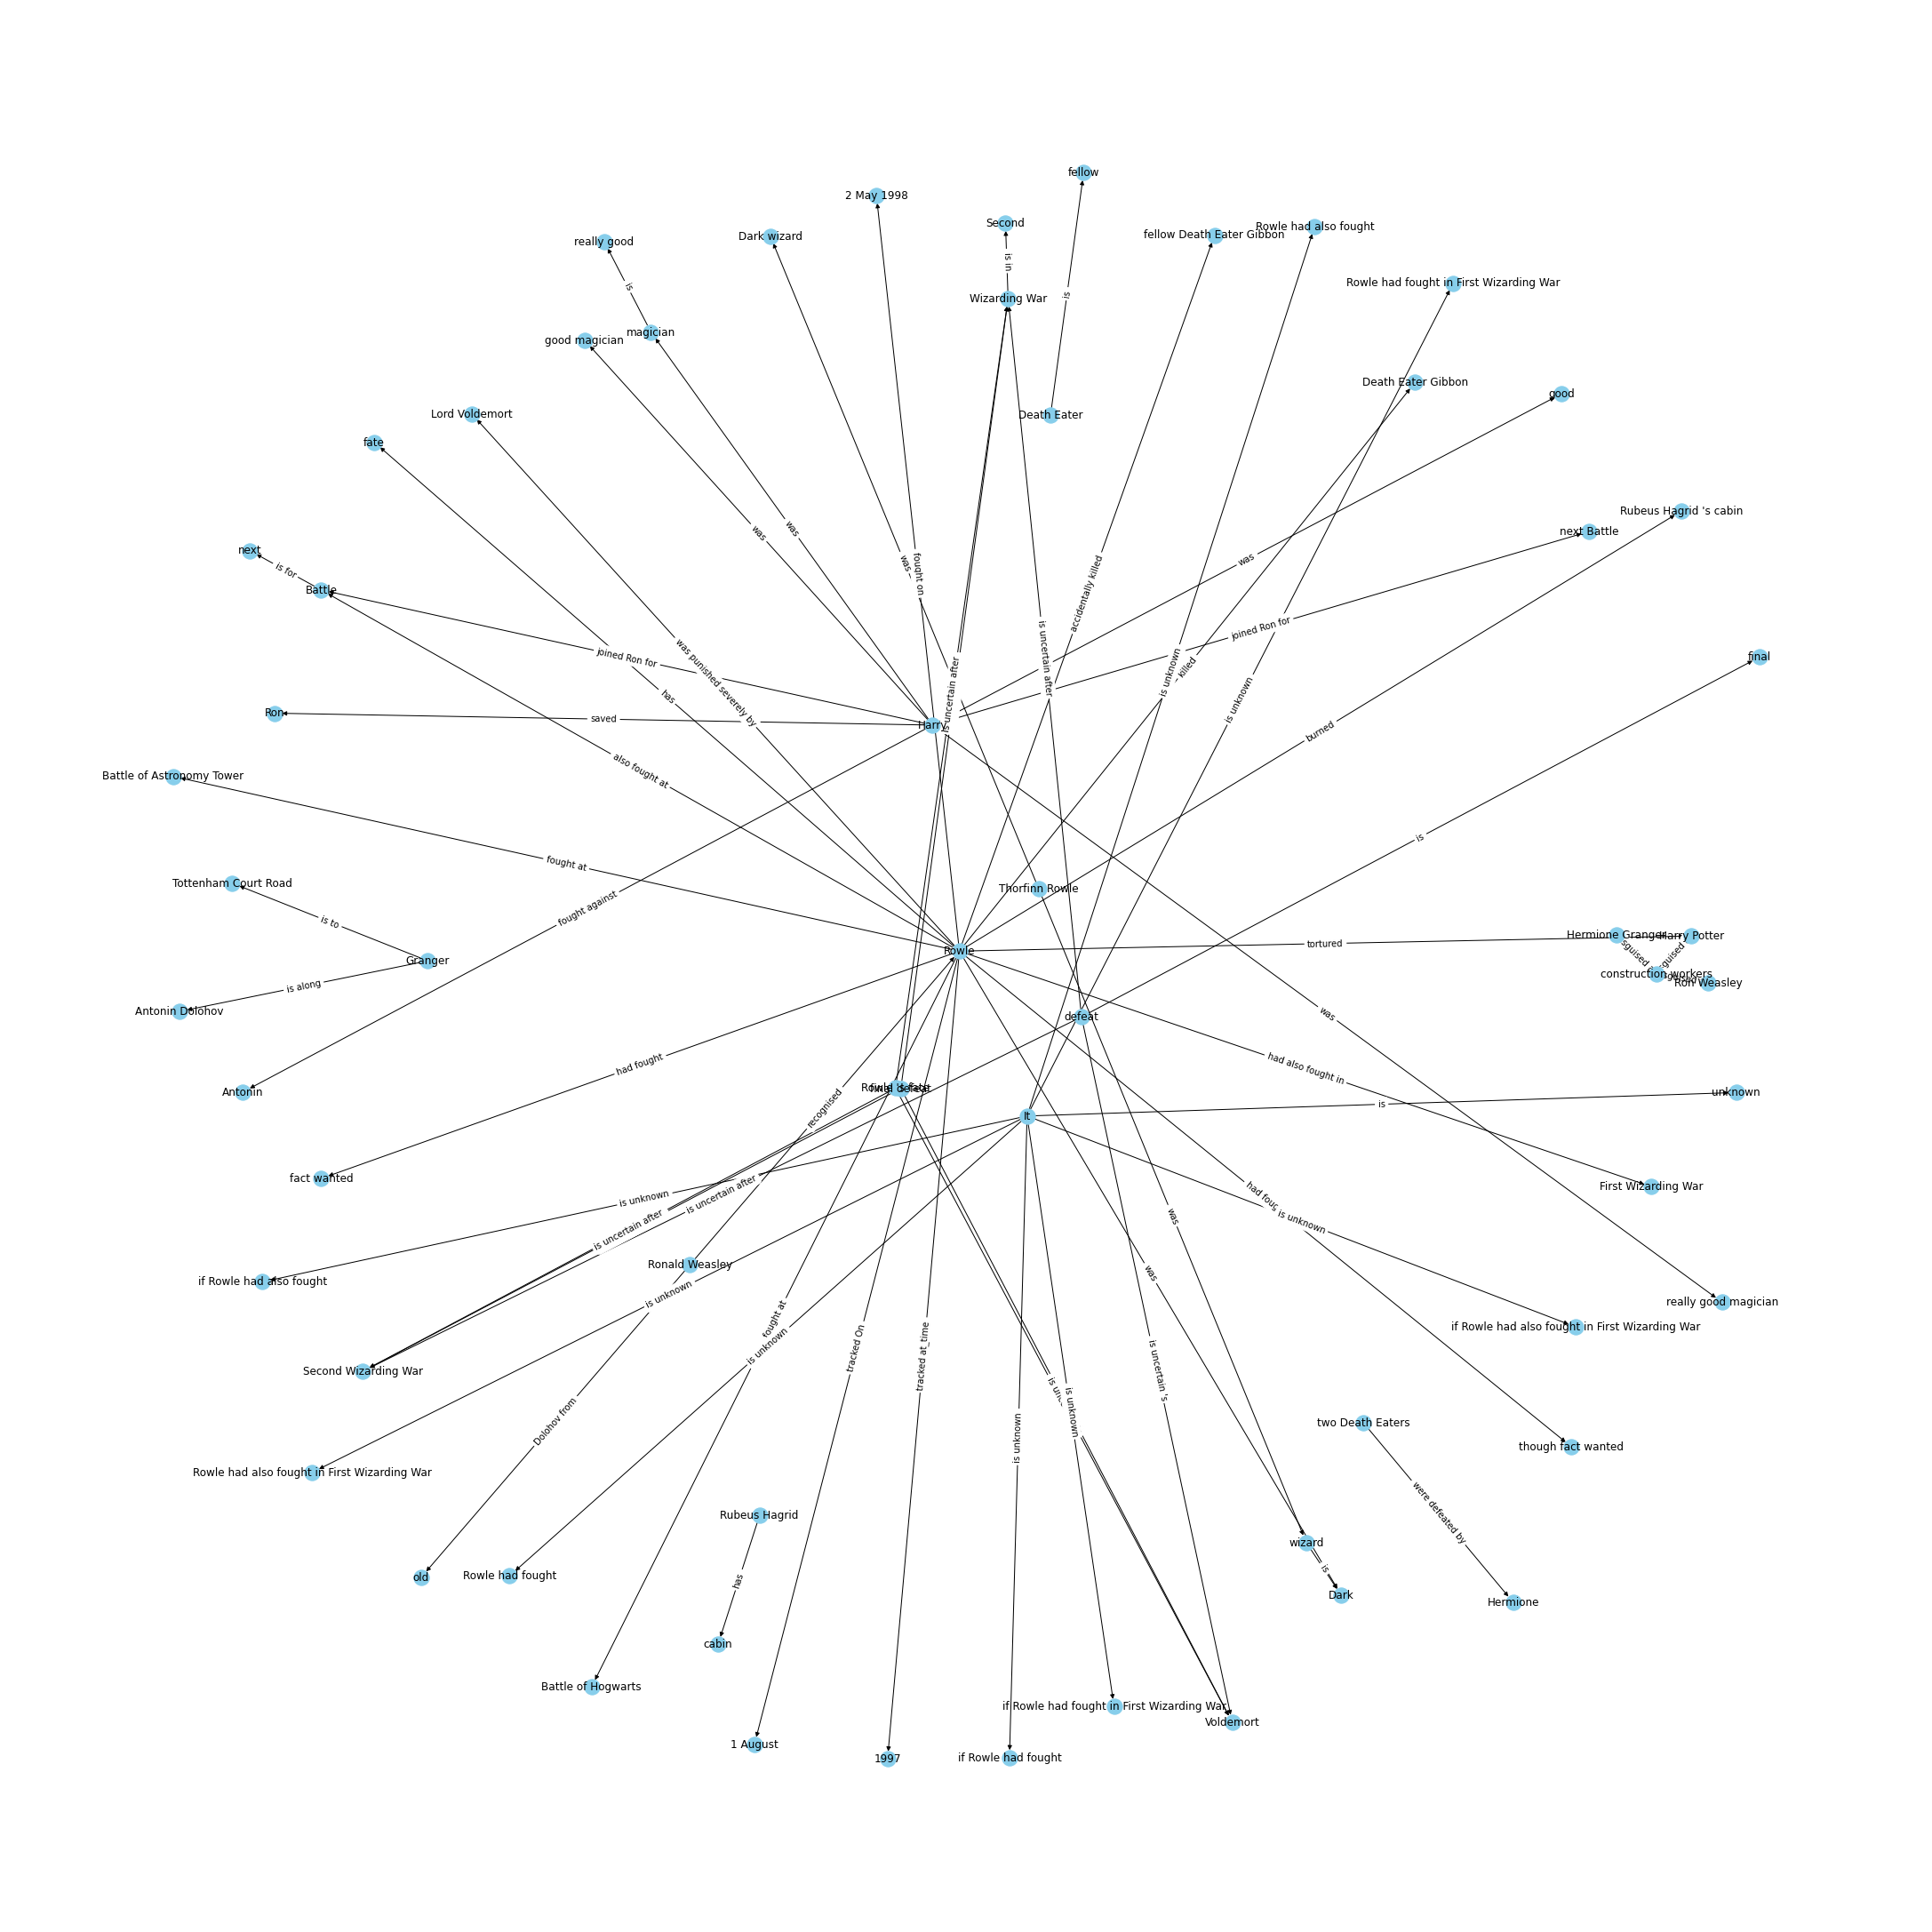

In [16]:
plt.figure(figsize=(30,30))

pos = nx.spring_layout(g)
nx.draw(g,with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, 
        pos=pos)
edge_labels = nx.get_edge_attributes(g, "relation")
nx.draw_networkx_edge_labels(g, pos, edge_labels)
plt.show()

In [18]:
# Example for random walk on the graph
random_walk(g, 20, 5)

['Rowle had fought',
 '1 August',
 'if Rowle had fought in First Wizarding War',
 'Battle of Astronomy Tower',
 'Rubeus Hagrid',
 'has',
 'cabin',
 'Hermione',
 'Antonin Dolohov',
 'construction workers',
 'good',
 'Death Eater',
 'is',
 'fellow',
 'though fact wanted',
 'Ron',
 'Antonin',
 'Rowle',
 'also fought at',
 'Battle',
 'is for',
 'next',
 'Tottenham Court Road',
 'Voldemort',
 'construction workers',
 'good magician',
 'Battle of Hogwarts',
 'Second']

# Run all cells below here first

# Imports

In [1]:
import spacy
from spacy import displacy
import en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [2]:
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
import pickle
import os
from nltk.tokenize import sent_tokenize
# import re
# import spacy
from fuzzywuzzy import process
# from spacy import displacy
from collections import Counter
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

C:\Users\Samar Syed\anaconda3\envs\doc2db\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [3]:
import time
start_time = time.time()
from datetime import timedelta
from tqdm.notebook import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

# Preprocessing

## Preparing batches

In [5]:
def prepare_batch_corpus(input_text, max_caracter=5000):
    import nltk
    # "input_text" is a list with one entry which is a long string of the text to be translated
    corpus = nltk.sent_tokenize(input_text)
    
    # Size information
    nb_sentence = len(corpus)

    # Batch information (reset these values after each batch finalization)
    batch = []
    batch_length = 0
    

    # All batches are stored in that list, which will bbe the output of the function
    batch_corpus = []
    
    # Going throug each sentence of the initial corpus to create the batches
    for idx, sentence in enumerate(corpus):
        
        # Are we dealing with the last sentence ?
        last_sentence = idx + 1 == nb_sentence

        # Checking the batch size before adding a new sentence in it
        hypothetical_length = batch_length + len(sentence)
        if hypothetical_length < max_caracter:
            batch.append(sentence)
            batch_length += len(sentence) # + len(joiner)
            
            # If sentence can be added to the corpus wa add it and don't save the corpus yet
            # Except if this is the last sentence
            if not last_sentence:
                continue
        
        # Finalizing batch beforee storing
        joined_batch = "".join(batch)
    
        # Save batch in the corpus
        batch_corpus.append(joined_batch)
        
        # Reseting batch parameters
        batch = []
        batch_length = 0
                    
    return batch_corpus

## Coreference resolution

In [6]:
def resolved_text_sentencizer(paragraphs):
    """Performs coreference resolution on a list of batches with raw input strings and returns a list of resolved batches"""
    from tqdm.notebook import tqdm
    import coreferee, spacy
    import spacy_transformers
    nlp = spacy.load('en_core_web_trf')
    nlp.add_pipe('coreferee')
    end = len(paragraphs)
    sentences = []
    for i, text in tqdm(enumerate(paragraphs), total=end):
        try:
            doc = nlp(text)
            resolved_sentence = []
            for i,token in enumerate(doc):
                res = doc._.coref_chains.resolve(doc[i])
                if type(res) == list:
                    res = " and ".join(r.text for r in res)
                elif res == None:
                    res = token.text
#                 print((token.text, doc._.coref_chains.resolve(doc[i])))
                resolved_sentence.append(res)
            resolved_text = " ".join(resolved_sentence)
            sentences.append(resolved_text)
        except:
            pass
    
    return sentences

# output = [sent for sent in sentences if 'president' in 
#           (' '.join([token.lemma_.lower() for token in nlp(sent)]))]
# print('Fact count:', len(output))
# for fact in range(len(output)):
#     print(str(fact+1)+'.', output[fact])

## Triples extraction

In [7]:
def triple_extraction(sentences, num_sentences):
    """Extract subject-relation-object triples from the given input string and returns list of triple dictionaries (triple corpus)"""
    print('extracting triples')
#     import pandas as pd
    from tqdm.notebook import tqdm
    end = num_sentences
    # print('Number of sentences: ', end)
    data = []

    from openie import StanfordOpenIE
    # https://stanfordnlp.github.io/CoreNLP/openie.html
# Default value of openie.affinity_probability_cap was 1/3.
    properties = {
#         'openie.affinity_probability_cap': 2 / 3
#         'openie.splitter.disable' : True,
        'openie.triple.strict' : False,
        'openie.triple.all_nominals': True
        
    }

    with StanfordOpenIE(properties=properties) as client:

        for i, sent in tqdm(enumerate(sentences), total=end):
            try:
        #         print('Current sentence: ', sent)
                extracted_triples = client.annotate(sent)
#                 for triple in extracted_triples: #add the oriningal sentence to the extratced triples
#                     triple['sentence'] = sent
        #         print('Found %s triples in the sentence.' % len(extracted_triples))
    #             for triple in extracted_triples:
    #                 print('|-', triple)
                data.extend(extracted_triples)
            except:
                pass
    triples_corpus = pd.DataFrame(data)
#     print('DataFrame appended. triples_corpus: ', triples_corpus)
    return triples_corpus

## Preprocessing pipeline

In [8]:
def text_processor_pipeline(text):
    from tqdm.notebook import tqdm
    import pickle
    from datetime import timedelta
    import time
    """Takes in a raw input string and performs, coreference resolution, pass2act and OpenIE triple extraction"""
    
    start_time = time.time()
    print('preparing batch corpus...')
    batch_corpus = prepare_batch_corpus(text)
    end_time = time.time()
    print('Batch corpus prepared. Number of paragraphs = ', len(batch_corpus))
    print('Time taken for preperation: ', str(timedelta(seconds=end_time-start_time)))
#     print(batch_corpus)
    
    with open(('batch_corpus' + '.pickle'), 'wb') as file:
        pickle.dump(batch_corpus, file)
    
    start_time = time.time()
    print('resolving sentences...')
    resolved_batches = resolved_text_sentencizer(batch_corpus)
    end_time = time.time()
    print('sentences resolved. Number of sentences = ', len(resolved_batches))
    print('Time taken for resolving: ', str(timedelta(seconds=end_time-start_time)))
#     print(resolved_batches)
    with open(('resolved_batches' + '.pickle'), 'wb') as file:
        pickle.dump(resolved_batches, file)

    active_sentences = resolved_batches
    
    start_time = time.time()
    triples_list = []
    end = len(active_sentences)
    print('extracting triples')
    triples_corpus = triple_extraction(active_sentences, end)
    end_time = time.time()
    print('Time taken for triple extraction: ', str(timedelta(seconds=end_time-start_time)))
    
    with open(('triples_corpus' + '.pickle'), 'wb') as file:
        pickle.dump(triples_corpus, file)
    
    return triples_corpus

In [9]:
def random_walk(g, nr_rdm_walks, len_rdm_walks):
        from random import sample
        import os
        import random
        import networkx as nx
        random_nodes = []
        for i in range(nr_rdm_walks):
            random_nodes.append(random.choice(list(g.nodes())))
        walk = []
        for node in random_nodes:
            prev_node = node
            i = 0
            while i < len_rdm_walks:
                walk.append(prev_node)
                if not list(g.neighbors(prev_node)):
                    break
                else: 
                    node = random.choice(list(g.neighbors(prev_node)))
                    selected_edges_relation = [e['relation'] for u,v,e in g.edges(data=True) if u == prev_node and v == node]
                    walk.append(selected_edges_relation[0]) # add relation
                    prev_node = node
                    i += 1
        return walk

In [10]:
def create_graph(relation_df):
    g = nx.from_pandas_edgelist(relation_df,
                                'subject',
                                'object',
                                 edge_attr='relation',
                                 create_using=nx.DiGraph(),) 
    return g

In [11]:
def find_sentences_with_highlights(highlights, paragraph, num_range):
    sentencesWithHighlights = []
    list_sents = sent_tokenize(paragraph)
    for i, sentence in enumerate(list_sents):
        for highlight in highlights:
            if highlight in sentence:
                start = 0
                end = len(list_sents)-1
                if i > num_range:
                    start = i - num_range
                if i < len(list_sents)-num_range:
                    end = i + num_range
                for j in range(start, end):
                    sentencesWithHighlights.append(list_sents[j])
                break
    return sentencesWithHighlights